In [1]:
#@title Step 1: Importing the necessary libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import time
import itertools
import os

In [3]:
#@title Step 2: Load preprocessed (sequenced) data; Splitting data into training and testing datasets

import pickle

# Load sequences and vehicle IDs from a file
with open('sequences_vehicle_ids.pkl', 'rb') as f:
#with open('sequences_vehicle_ids.pkl', 'rb') as f:
    sequences, vehicle_ids = pickle.load(f)

# Split data into training and testing
train_size = int(0.8 * len(sequences))
train_sequences = sequences[:train_size]
test_sequences = sequences[train_size:]
train_vehicle_ids = vehicle_ids[:train_size]
test_vehicle_ids = vehicle_ids[train_size:]

class VehicleDataset(Dataset):
    def __init__(self, sequences, flatten=False):
        self.sequences = sequences
        self.flatten = flatten # new

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq, target = self.sequences[idx]
        seq_tensor = torch.Tensor(seq)
        if self.flatten:
            seq_tensor = seq_tensor.view(-1)  # Flatten the sequence
        return seq_tensor, torch.Tensor(target)

# Create DataLoader objects for the full dataset
train_dataset_all = VehicleDataset(train_sequences, flatten=False)
test_dataset_all = VehicleDataset(test_sequences, flatten=False)

train_loader = DataLoader(train_dataset_all, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_all, batch_size=32, shuffle=False)


In [4]:
#@title Step 3: Defining the methods (architecture of NN layers and activation functions)

#### Step 3a: Define the Long Short-Term Memory (LSTM) model

import torch.nn as nn
import torch.nn.functional as F

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

#### Step 3b: Define the Gated Recurrent Unit (GRU) model

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


#### Step 3c: Define the generic Recurrent Neural Network (RNN) model

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


#### Step 3d: Define 1-d CNN (Conv1D) model

class Conv1DModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(Conv1DModel, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()

        # Input layer
        self.conv_layers.append(nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1))
        self.pool_layers.append(nn.MaxPool1d(kernel_size=2, stride=1))  # Reduced stride

        # Hidden layers
        for _ in range(1, num_layers):
            self.conv_layers.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1))
            self.pool_layers.append(nn.MaxPool1d(kernel_size=2, stride=1))  # Reduced stride

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.transpose(1, 2)  # Swap dimensions to fit Conv1d input format
        for conv, pool in zip(self.conv_layers, self.pool_layers):
            x = F.relu(conv(x))
            x = pool(x)
        x = x.mean(dim=2)  # Global average pooling
        x = self.fc(x)
        return x
    
#### Step 3e: Define a simple Multi-layer Perceptron (MLP) model

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MLPModel, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]

        for _ in range(1, num_layers):
            layers.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])

        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x.view(x.size(0), -1))

In [5]:
#@title Step 4: Training method (generic for all baselines)

def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cuda', early_stopping_rounds=4, min_delta=0.01):
    model.to(device)
    epoch_times = []
    epoch_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_loss = 0
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        average_loss = total_loss / len(train_loader)
        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)
        epoch_losses.append(average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.8f}, Time: {epoch_time:.2f}s')

        # Early stopping mechanism
        if epoch >= early_stopping_rounds:
          recent_losses = epoch_losses[-early_stopping_rounds:]
          if all(abs(recent_losses[i] - recent_losses[i-1]) < min_delta * recent_losses[i-1] for i in range(1, early_stopping_rounds)):
              print(f"Early stopping at epoch {epoch+1}")
              break

    return epoch_times, epoch_losses

In [6]:
#@title Step 5: Model Evaluation

from sklearn.metrics import mean_absolute_error, r2_score

def evaluate_model(model, test_loader, device='cuda'):
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print(f'RMSE: {rmse:.8f}')
    print(f'MAE: {mae:.8f}')
    print(f'R2 Score: {r2:.8f}')

    return predictions, actuals, rmse, mae, r2

In [9]:
#@title Step 6: Define a method to run the training and evaluation of the model for different sets of hyperparameters

def run_experiment(params, input_size=4, output_size=2, model_type='LSTM'):
    hidden_size, num_layers, learning_rate, num_epochs = params

    if model_type == 'LSTM':
        model = LSTMModel(input_size, hidden_size, num_layers, output_size)
        save_path = 'experiment_results_LSTM.csv'
    elif model_type == 'GRU':
        model = GRUModel(input_size, hidden_size, num_layers, output_size)
        save_path = 'experiment_results_GRU.csv'
    elif model_type == 'RNN':
        model = RNNModel(input_size, hidden_size, num_layers, output_size)
        save_path = 'experiment_results_RNN.csv'
    elif model_type == 'Conv1D':
        model = Conv1DModel(input_size, hidden_size, num_layers, output_size)
        save_path = 'experiment_results_Conv1D.csv'
    elif model_type == 'MLP':
        example_input, _ = next(iter(train_loader))
        flattened_input_size = example_input.view(example_input.size(0), -1).size(1)
        model = MLPModel(flattened_input_size, hidden_size, num_layers, output_size)
        save_path = 'experiment_results_MLP.csv'
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Initialize criterion and optimizer
    criterion = nn.MSELoss() # mean squared error (MSE) is the criterion for evaluating loss in each epoch
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Using Adam optimizer

    # Train the model and measure time
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Use the provided train_model function
    epoch_times, epoch_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

    # Evaluate the model
    predictions, actuals, rmse, mae, r2 = evaluate_model(model, test_loader, device=device)

    # Calculate average epoch time
    avg_epoch_time = np.mean(epoch_times)

    result = {
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'avg_epoch_time': avg_epoch_time,
        'epoch_losses': epoch_losses
    }

    results_df = pd.DataFrame([result])
    if save_path:
        if os.path.exists(save_path):
            results_df.to_csv(save_path, mode='a', header=False, index=False)
        else:
            results_df.to_csv(save_path, index=False)

    return result


In [10]:
#@title Step 7: Execute the experiment for each model type with the selected hyperparameters

# set of hyperparameters for each model type consists of (hidden_size, num_layers, learning_rate, num_epochs)
hyperparameters = {
    'GRU': (100, 3, 0.0005, 30),
    'LSTM': (100, 4, 0.0005, 30),
    'RNN': (100, 2, 0.0005, 30),
    'Conv1D': (100, 2, 0.01, 30),
    'MLP': (100, 3, 0.00005, 30)
}

# Loop through each model type and run the experiment with the corresponding hyperparameters
for model_type, params in hyperparameters.items():
    print(f"Running experiment for model {model_type} with parameters {params}")
    result = run_experiment(params, model_type=model_type)
    print(f"Result for model {model_type}: {result}\n----------------------------\n")

Running experiment for model GRU with parameters (100, 3, 0.0005, 30)
Epoch [1/30], Loss: 455231.41204199, Time: 116.93s
Epoch [2/30], Loss: 11293.87978058, Time: 115.68s
Epoch [3/30], Loss: 261.20075519, Time: 116.15s
Epoch [4/30], Loss: 116.79541325, Time: 119.29s
Epoch [5/30], Loss: 101.25832057, Time: 120.07s
Epoch [6/30], Loss: 101.23078028, Time: 119.16s
Epoch [7/30], Loss: 92.18078007, Time: 119.26s
Epoch [8/30], Loss: 89.59829003, Time: 120.32s
Epoch [9/30], Loss: 84.14662551, Time: 119.55s
Epoch [10/30], Loss: 79.64164346, Time: 114.92s
Epoch [11/30], Loss: 80.45706919, Time: 115.30s
Epoch [12/30], Loss: 67.38301517, Time: 117.13s
Epoch [13/30], Loss: 67.09111132, Time: 116.97s
Epoch [14/30], Loss: 66.15893062, Time: 115.84s
Epoch [15/30], Loss: 66.44310698, Time: 116.96s
Epoch [16/30], Loss: 65.03534897, Time: 116.02s
Epoch [17/30], Loss: 67.31681910, Time: 116.99s
Epoch [18/30], Loss: 71.74648059, Time: 116.54s
Epoch [19/30], Loss: 72.40753812, Time: 116.77s
Epoch [20/30], L

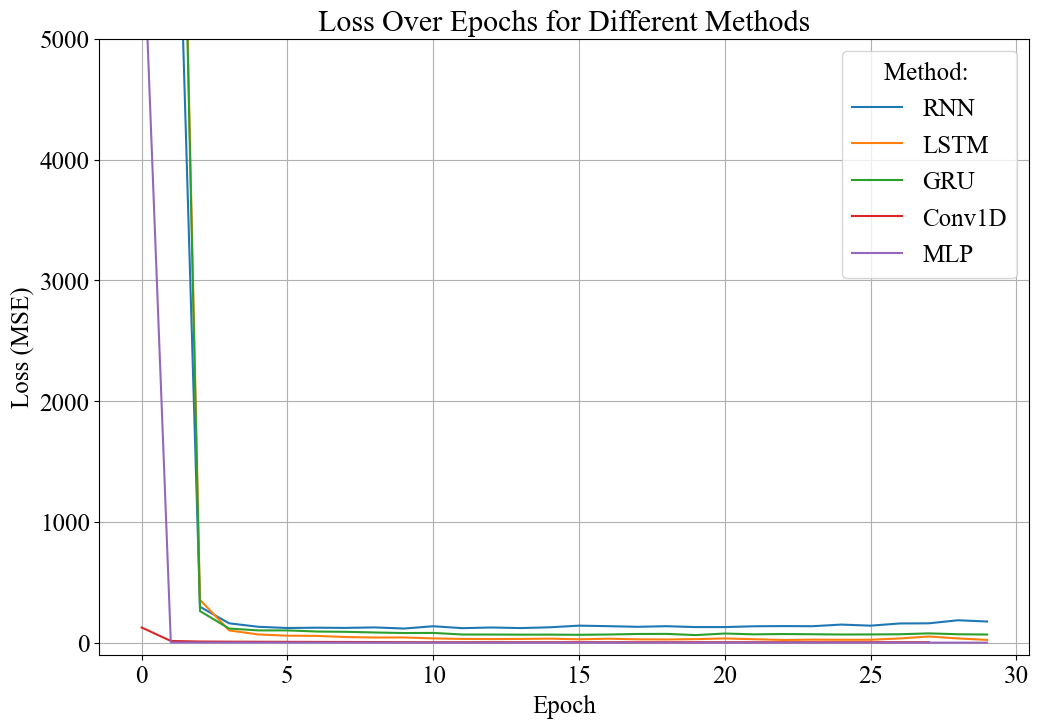

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Load the CSV file
file_path = 'experiment_methods.csv'
df = pd.read_csv(file_path)

# Convert the 'epoch_losses' column from a string representation of a list to an actual list
df['epoch_losses'] = df['epoch_losses'].apply(ast.literal_eval)

# Set global font to Times New Roman and size to 18
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18

# Plot the losses
plt.figure(figsize=(12, 8))

for index, row in df.iterrows():
    plt.plot(row['epoch_losses'], label=row['method_type'])

plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.ylim(-100, 5000)
plt.title('Loss Over Epochs for Different Methods')
plt.legend(title="Method: ", prop={'size': 18})
plt.grid(True)
plt.savefig('graphs/loss-over-epochs-non-zoomed.svg')
plt.show()


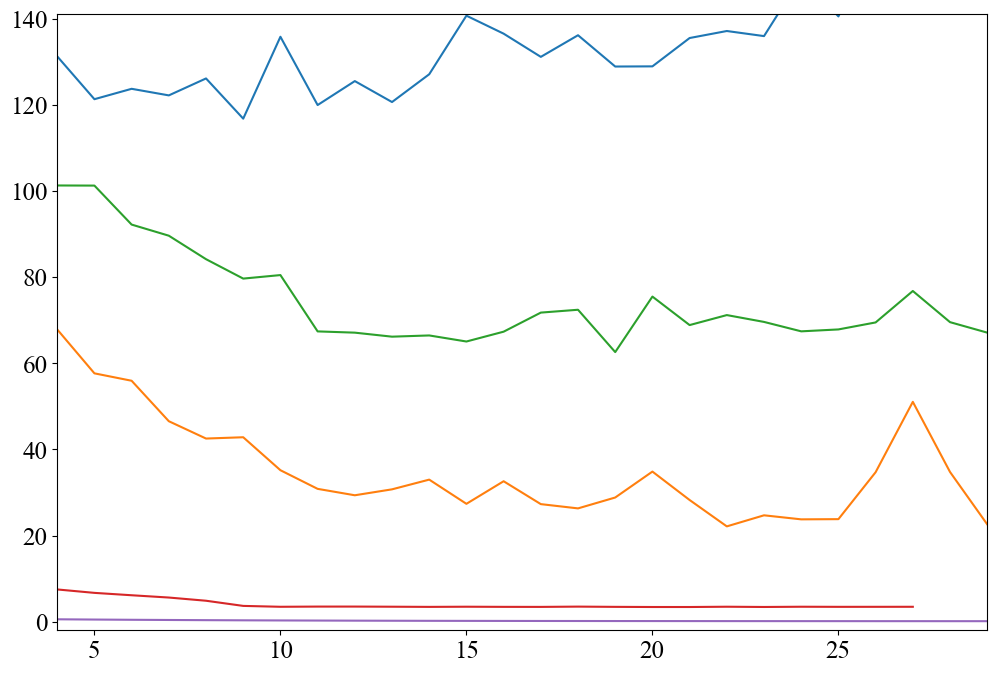

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Load the CSV file
file_path = 'experiment_methods.csv'
df = pd.read_csv(file_path)

# Convert the 'epoch_losses' column from a string representation of a list to an actual list
df['epoch_losses'] = df['epoch_losses'].apply(ast.literal_eval)

# Plotting the losses
plt.figure(figsize=(12, 8))

for index, row in df.iterrows():
    # Slice the losses from epoch 4 onwards
    plt.plot(range(4, len(row['epoch_losses'])), row['epoch_losses'][4:], label=row['method_type'])

# Set the x and y axis limits
# plt.xlim(8, len(df.iloc[0]['epoch_losses']) - 1)
# plt.ylim(0, 80)

plt.xlim(4, len(df.iloc[0]['epoch_losses']) - 1)
plt.ylim(-2, 141)
# plt.ylim(-2, 186)

# # Labels and title
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss Over Epochs for Different Methods (Zoomed In)')
# plt.legend(title="Method Type")
# plt.grid(True)

# Show the plot
plt.savefig('graphs/loss-over-epochs-zoomed.svg')
plt.show()


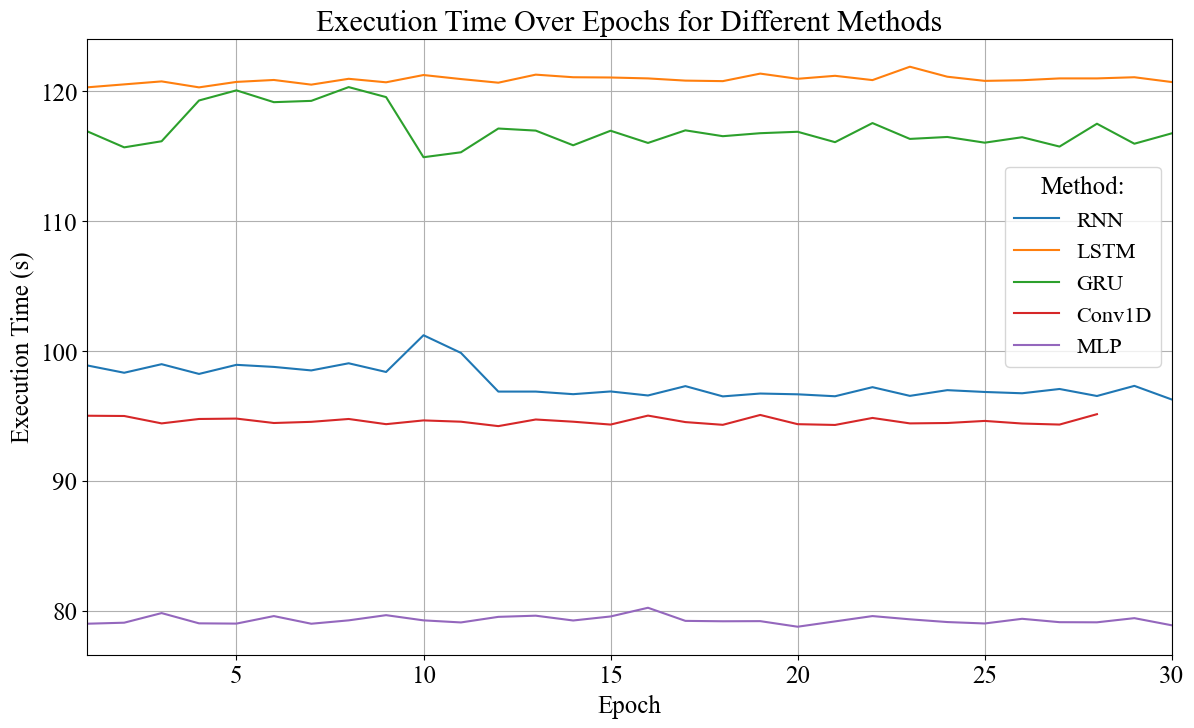

In [104]:
# Manually extracted execution times from notebook output
execution_times = {
    'RNN': [98.89, 98.32, 98.98, 98.23, 98.93, 98.77, 98.50, 99.05, 98.38, 101.21,
            99.85, 96.87, 96.87, 96.67, 96.88, 96.57, 97.29, 96.50, 96.72, 96.66,
            96.51, 97.21, 96.54, 96.98, 96.84, 96.74, 97.07, 96.53, 97.31, 96.26],
    'LSTM': [120.30, 120.53, 120.76, 120.30, 120.72, 120.87, 120.51, 120.96, 120.69, 121.25,
             120.94, 120.66, 121.28, 121.08, 121.06, 120.99, 120.82, 120.78, 121.36, 120.96,
             121.19, 120.86, 121.89, 121.12, 120.80, 120.85, 120.99, 120.99, 121.08, 120.71],    
    'GRU': [116.93, 115.68, 116.15, 119.29, 120.07, 119.16, 119.26, 120.32, 119.55, 114.92,
            115.30, 117.13, 116.97, 115.84, 116.96, 116.02, 116.99, 116.54, 116.77, 116.88,
            116.08, 117.55, 116.33, 116.48, 116.04, 116.46, 115.74, 117.50, 115.96, 116.76],
    'Conv1D': [95.01, 94.99, 94.42, 94.76, 94.79, 94.45, 94.54, 94.76, 94.36, 94.65,
               94.55, 94.21, 94.72, 94.55, 94.33, 95.02, 94.52, 94.31, 95.07, 94.36,
               94.30, 94.84, 94.42, 94.45, 94.61, 94.41, 94.33, 95.13],
    'MLP': [78.99, 79.07, 79.81, 79.02, 79.00, 79.58, 78.99, 79.25, 79.65, 79.25,
            79.09, 79.52, 79.61, 79.24, 79.55, 80.22, 79.21, 79.18, 79.19, 78.76,
            79.17, 79.58, 79.33, 79.12, 79.01, 79.37, 79.11, 79.10, 79.42, 78.87]
}

# Plotting Execution Time for Each Epoch
plt.figure(figsize=(14, 8))

for method, times in execution_times.items():
    plt.plot(range(1, len(times) + 1), times, label=method)

plt.xlabel('Epoch')
plt.xlim(1, 30)
plt.ylabel('Execution Time (s)')
plt.title('Execution Time Over Epochs for Different Methods')
plt.legend(title="Method:", prop={'size': 16}, loc='center right', bbox_to_anchor=(1, 0.63))
plt.grid(True)
plt.savefig('graphs/exec-time-per-epoch.svg')
plt.show()


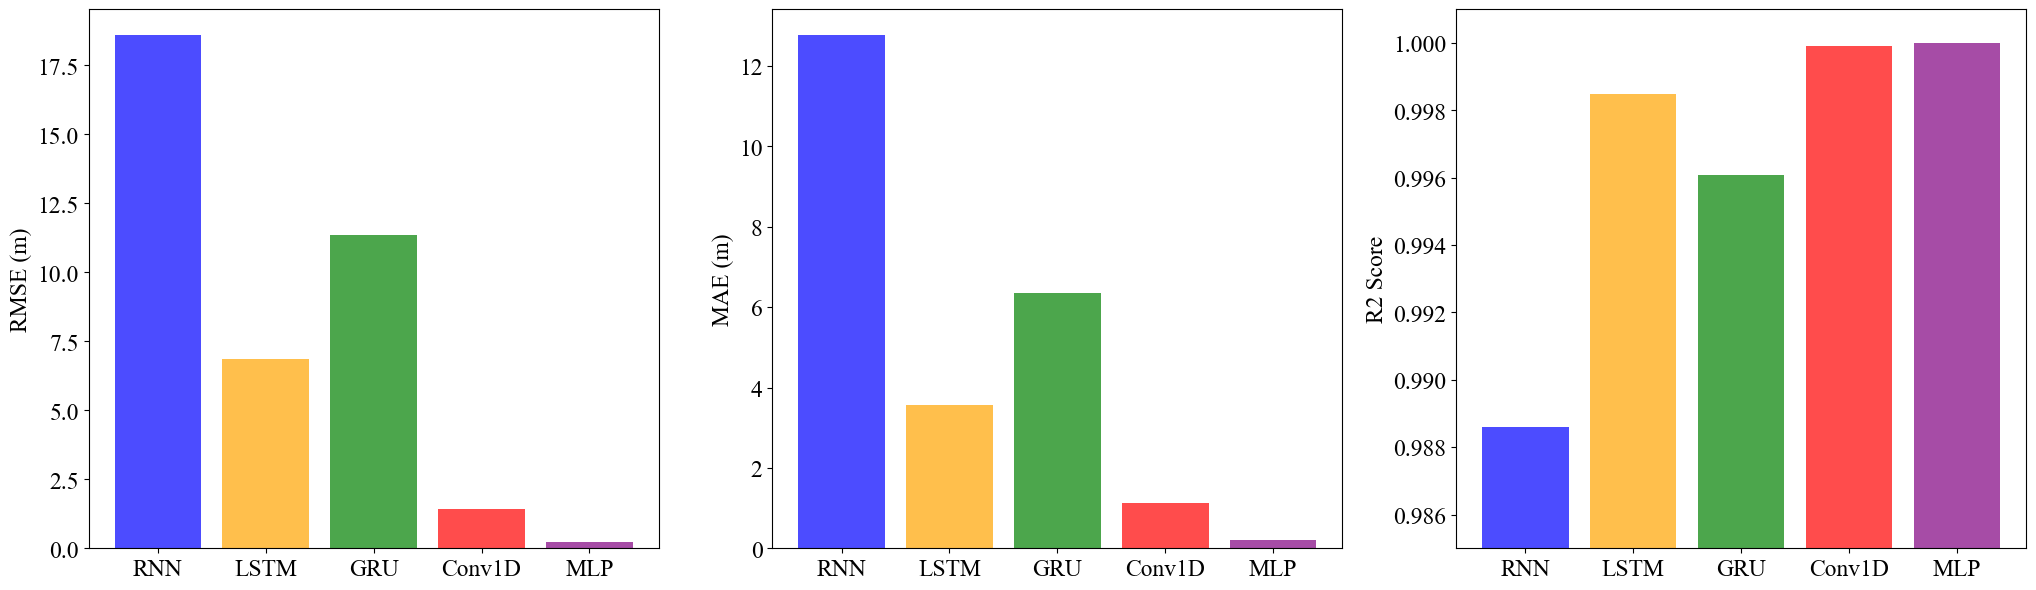

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

# Load the CSV file
file_path = 'experiment_methods.csv'
df = pd.read_csv(file_path)

# Extract the metrics
methods = df['method_type']
rmse_values = df['rmse']
mae_values = df['mae']
r2_values = df['r2']

# Define the original color mapping
color_mapping = {
    'RNN': 'blue',
    'LSTM': 'orange',
    'GRU': 'green',
    'Conv1D': 'red',
    'MLP': 'purple'
}

# Lighten the colors
def lighten_color(color, amount=0.7):
    return to_rgba(color, alpha=amount)

# Apply lighter colors
light_colors = [lighten_color(color_mapping[method], amount=0.7) for method in methods]

# Plotting RMSE, MAE, R2 for each method as a bar plot
# Set global font to Times New Roman and size to 18
# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 17
fig, ax = plt.subplots(1, 3, figsize=(25, 7))

ax[0].bar(methods, rmse_values, color=light_colors)
ax[0].set_ylabel('RMSE (m)')

ax[1].bar(methods, mae_values, color=light_colors)
ax[1].set_ylabel('MAE (m)')

ax[2].bar(methods, r2_values, color=light_colors)
ax[2].set_ylabel('R2 Score')
ax[2].set_ylim(0.985, 1.001)  # Limit the y-axis from 0.985 to 1.001

plt.savefig('graphs/rmse-mae-r2score-methods.svg')
plt.show()
